## Advanced Lane Finding Project

The steps of this project are the following:

* Get challenging image frames from videos and add to test images.
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Apply the lane finding pipeline to 3 videos.

## Get challenging image frames from videos and add to test images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt
%matplotlib inline

# Extract frames from clip
def extract_frames(clip, times, imgdir):
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)
        
imgdir = 'test_images'

challenge_clip = VideoFileClip("challenge_video.mp4")
times = 2, 3
extract_frames(challenge_clip, times, imgdir)

hardchallenge_clip = VideoFileClip("harder_challenge_video.mp4")
times = 2.5, 5
extract_frames(hardchallenge_clip, times, imgdir)
print("Done with image extraction.")

Done with image extraction.


## Compute the camera calibration using chessboard images

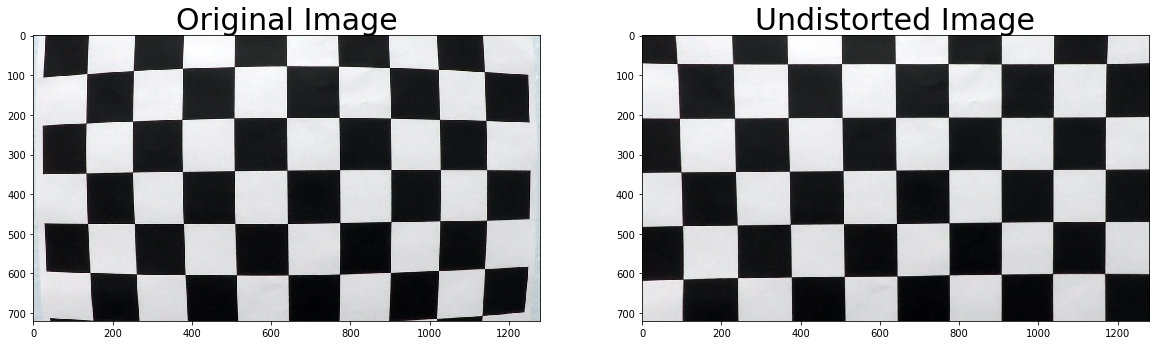

Done with camera calibration.


In [3]:
   
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

# Load image to get image shape
img = cv2.imread(images[0])
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#Test undistortion on an image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()
print("Done with camera calibration.")

## Apply a distortion correction to raw test images.

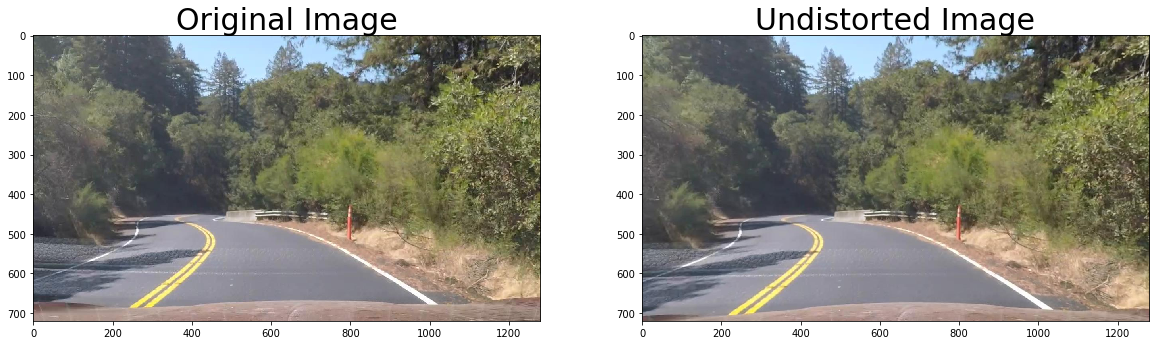

Done with distortion correction.


In [5]:
def undistort(img, mtx, dist):
    """ Distortion correct image, using camera calibration mtx and dist."""
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

# Create undistorted directory, if it doesn't exist
undistorted_dir = 'output_images/undistorted/'
if not os.path.exists(undistorted_dir):
    os.mkdir(undistorted_dir)

# Make a list of test images
testimages = glob.glob('test_images/*.jpg')

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 0

idx = 0
# Step through the list and apply distortion correction
for fname in testimages:
    idx += 1
    img = cv2.imread(fname)
    filename = os.path.basename(fname)
    dst = undistort(img, mtx, dist)
    cv2.imwrite(undistorted_dir+filename,dst)
    if (all_debug_plots) or (idx == 1):
        # Visualize undistortion
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=30)
        plt.show()
print("Done with distortion correction.")

## Use color transforms, gradients, etc., to create a thresholded binary image.

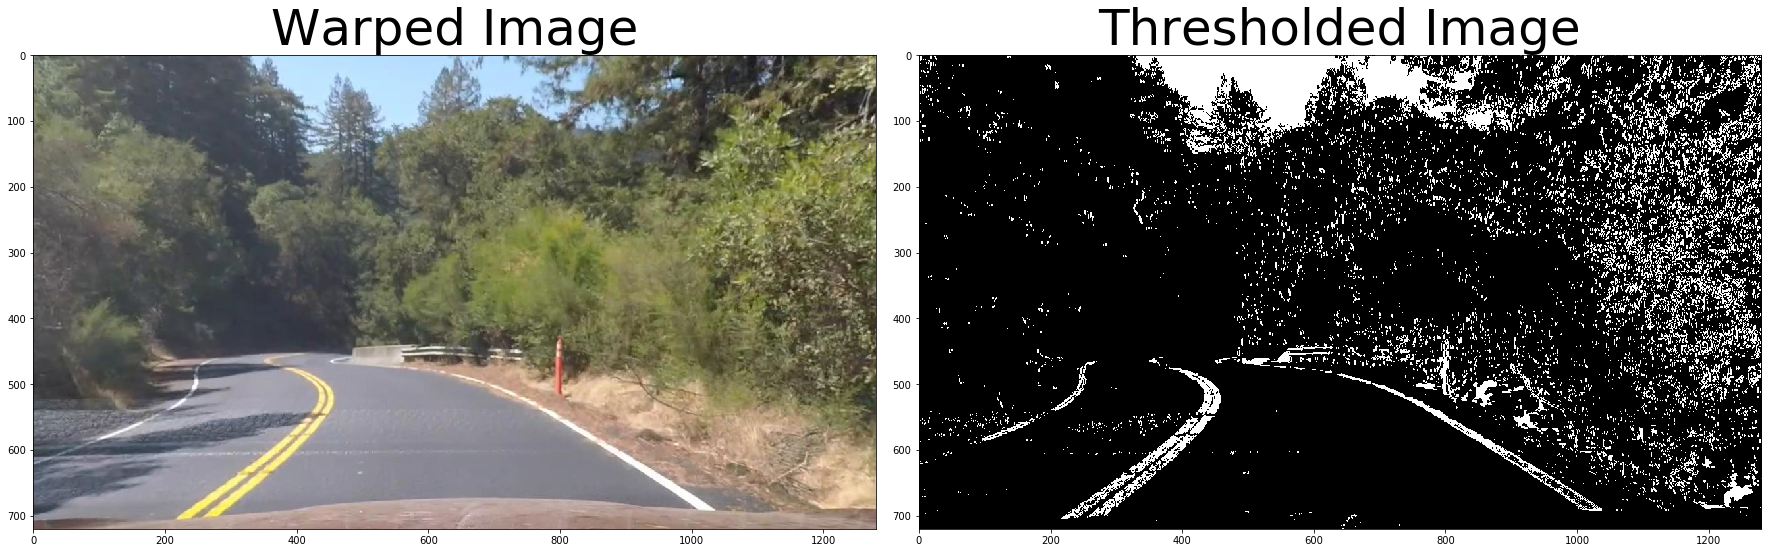

Done with thresholding.


In [13]:
def thresholding(img, l_thresh=(255, 255), s_thresh=(255,255), sx_thresh=(90, 90), sobel_kernel=3):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold l channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1 
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(l_binary == 1) | (s_binary == 1) | (sxbinary == 1)] = 255
    return combined_binary

# Create warped directory, if it doesn't exist
thresh_dir = 'output_images/thresholded/'
if not os.path.exists(thresh_dir):
    os.mkdir(thresh_dir)

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 0

# Make a list of undistorted images
undistimages = glob.glob(undistorted_dir+'*.jpg')

idx = 0
# Step through the list and apply thresholding
for fname in undistimages:
    idx += 1
    
    img = cv2.imread(fname)
    filename = os.path.basename(fname)
    thresholded = thresholding(img, l_thresh=(200, 250), s_thresh=(200, 250), sx_thresh=(30, 90))
    cv2.imwrite(thresh_dir+filename,thresholded)

    # Plot the original and warped images (convert back to RGB for matplotlib)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    thresholded = cv2.cvtColor(thresholded,cv2.COLOR_BGR2RGB)
    if all_debug_plots or idx == 1:        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Warped Image', fontsize=50)
        ax2.imshow(thresholded)
        ax2.set_title('Thresholded Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        
print("Done with thresholding.")

## Apply a perspective transform to rectify binary image ("birds-eye view").

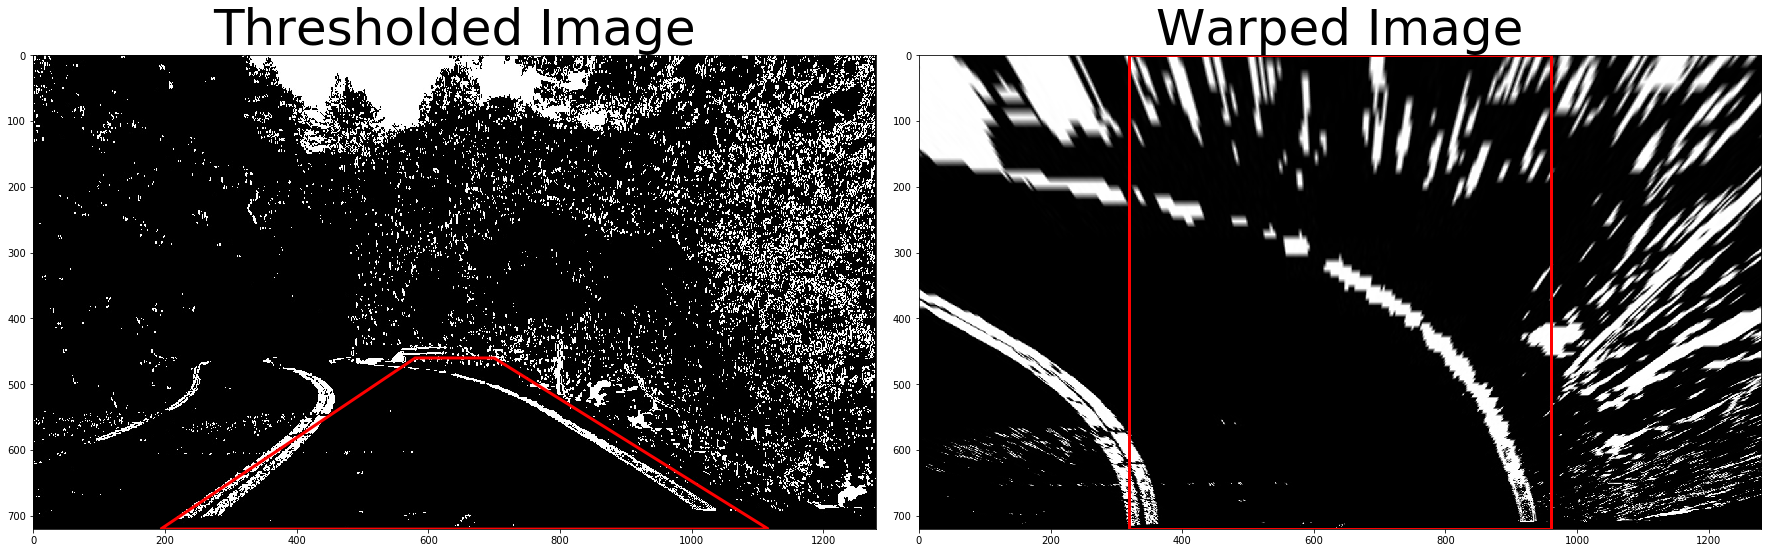

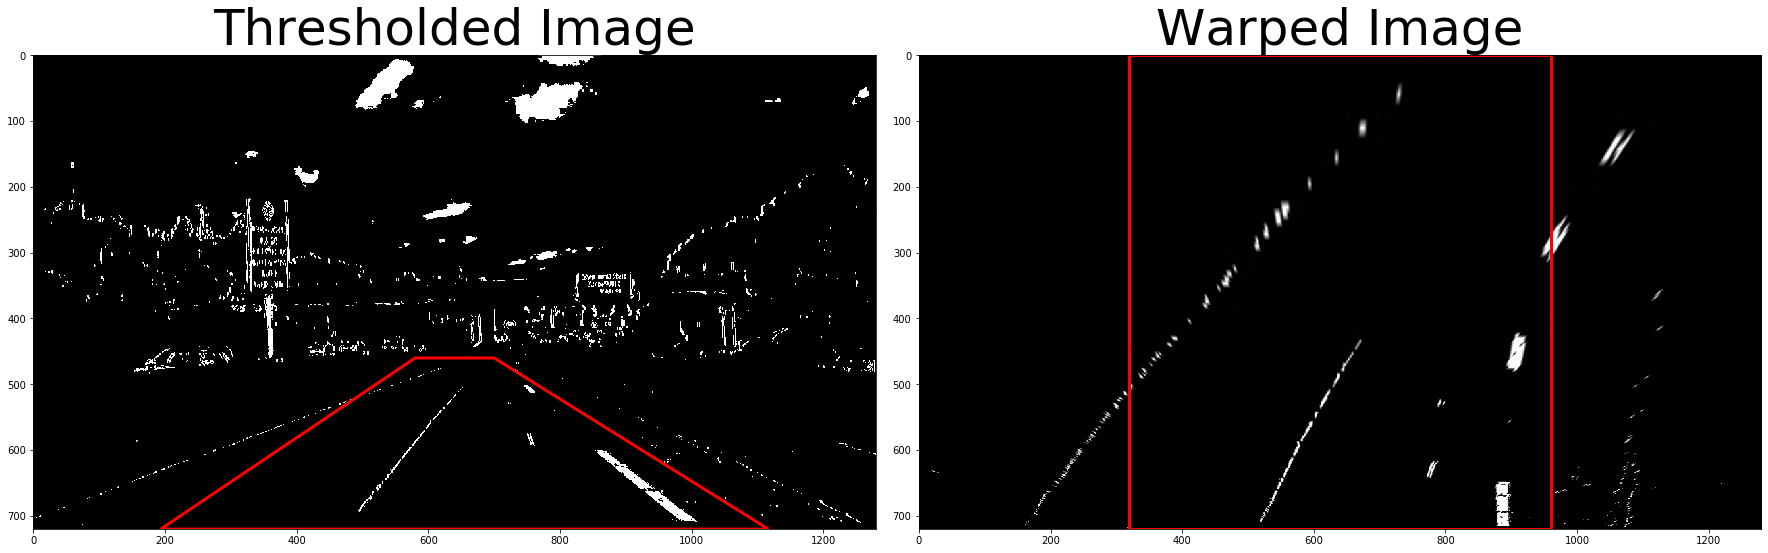

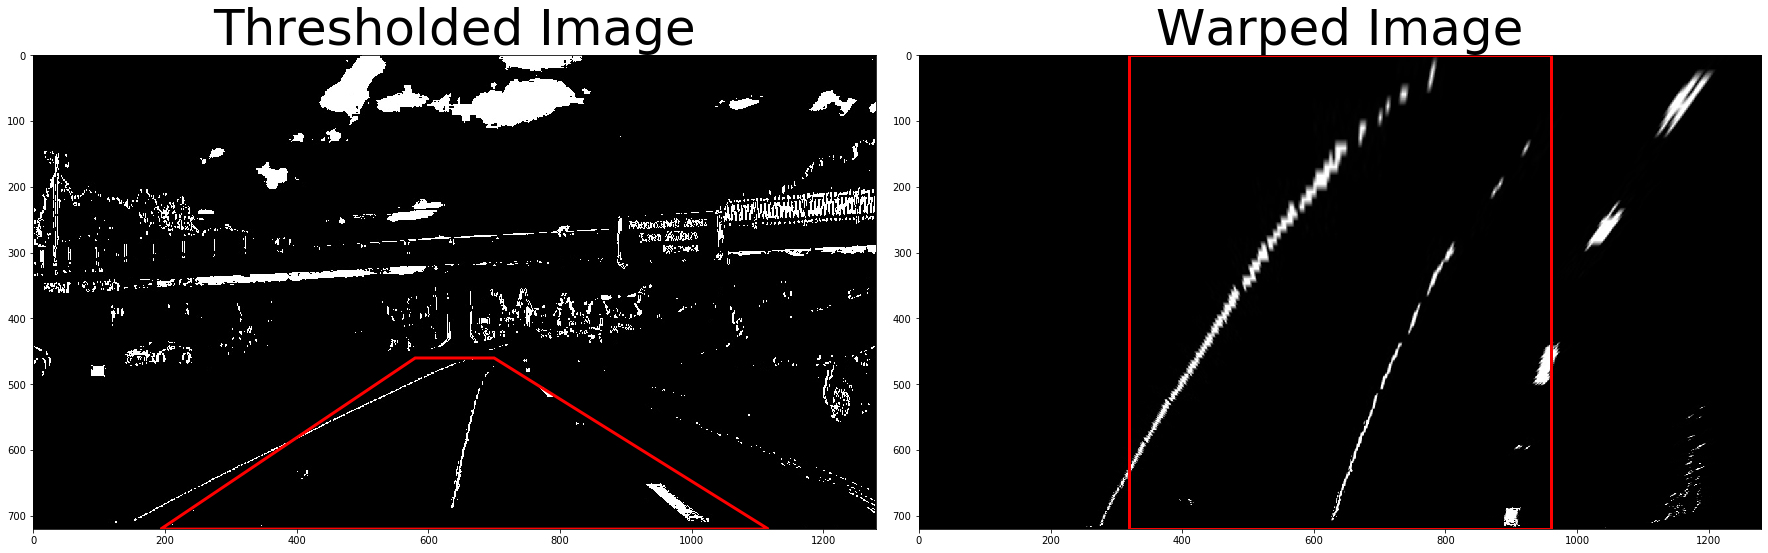

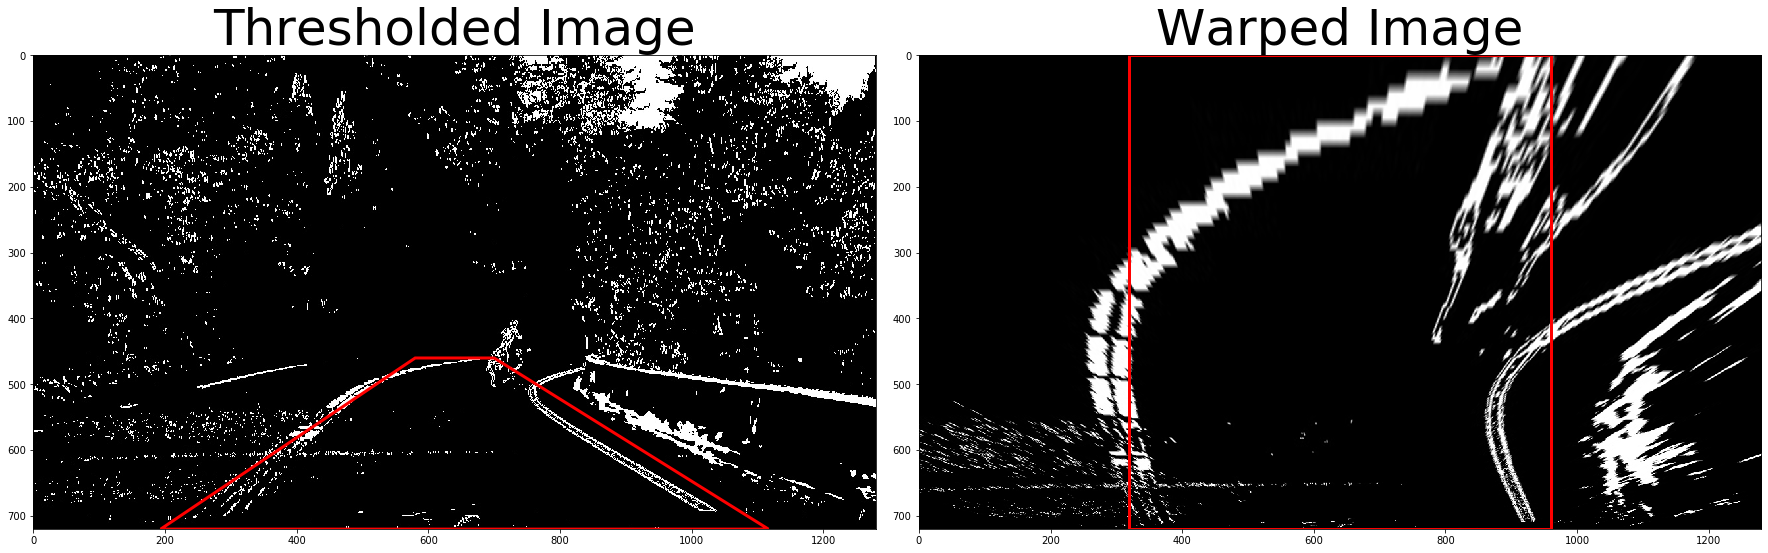

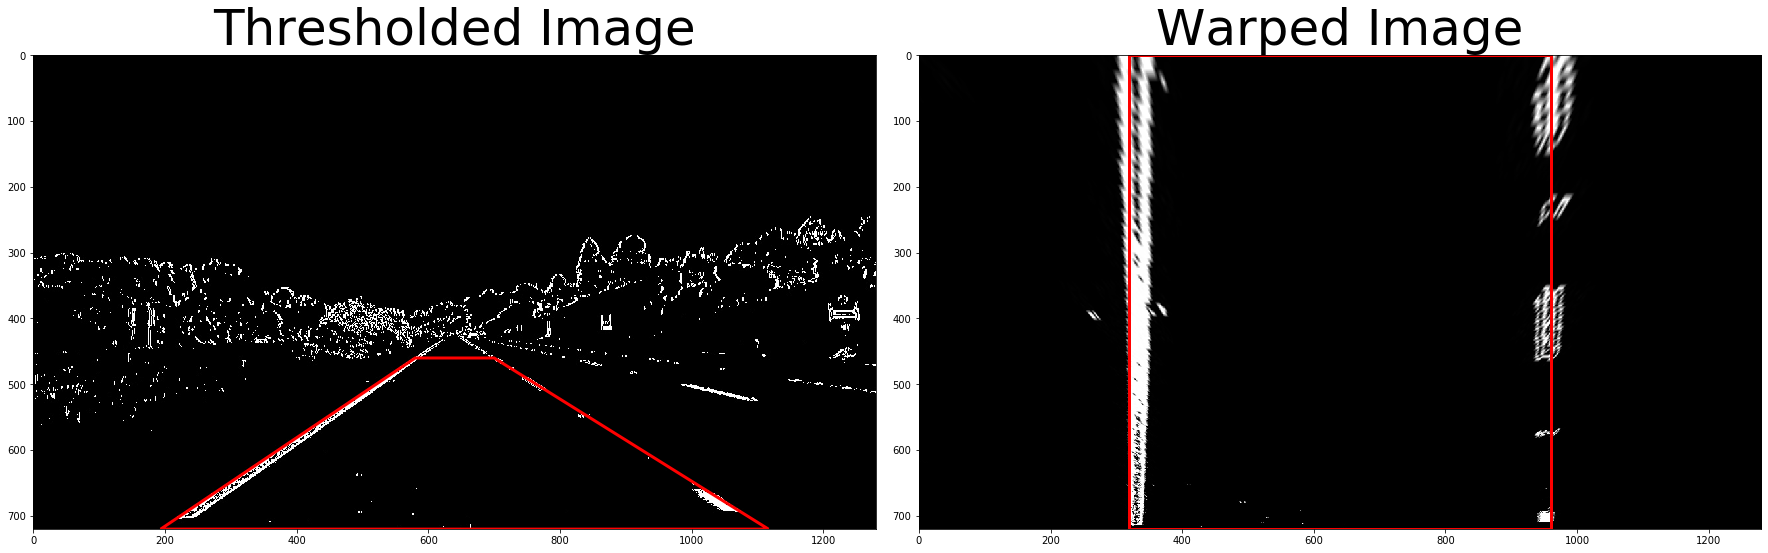

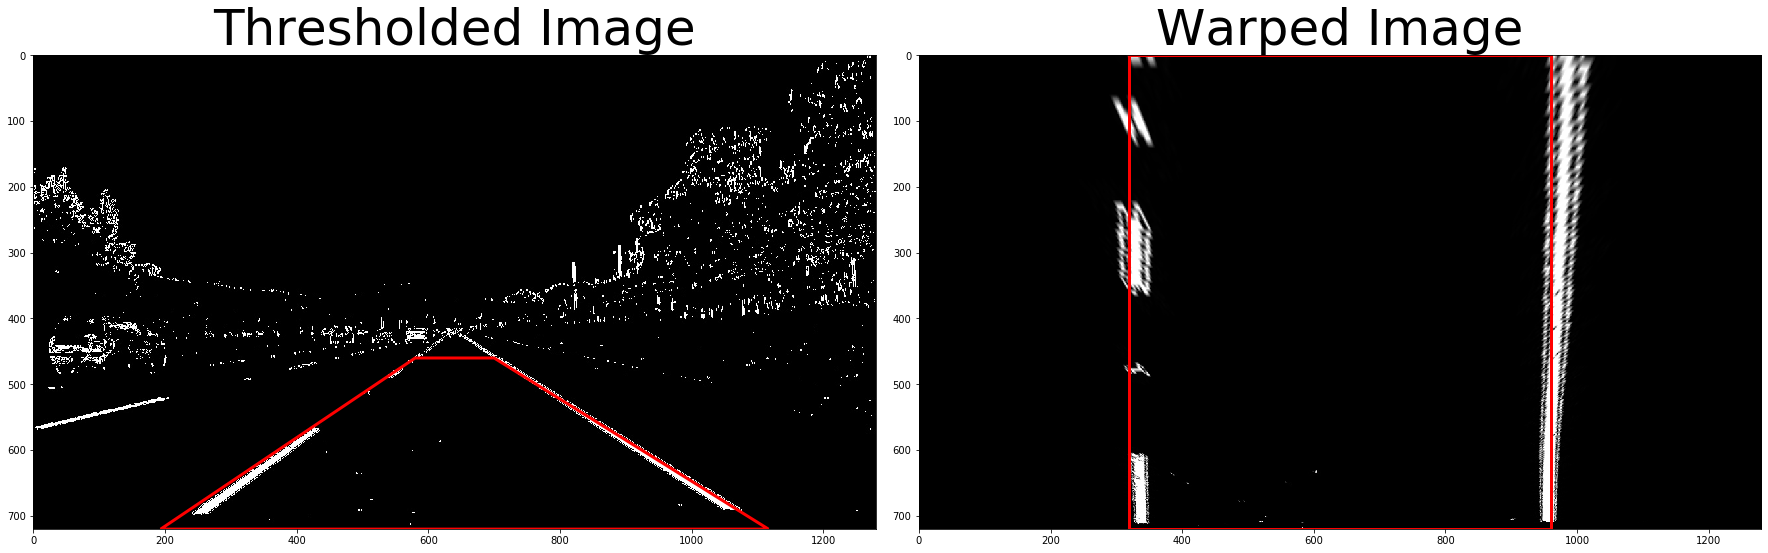

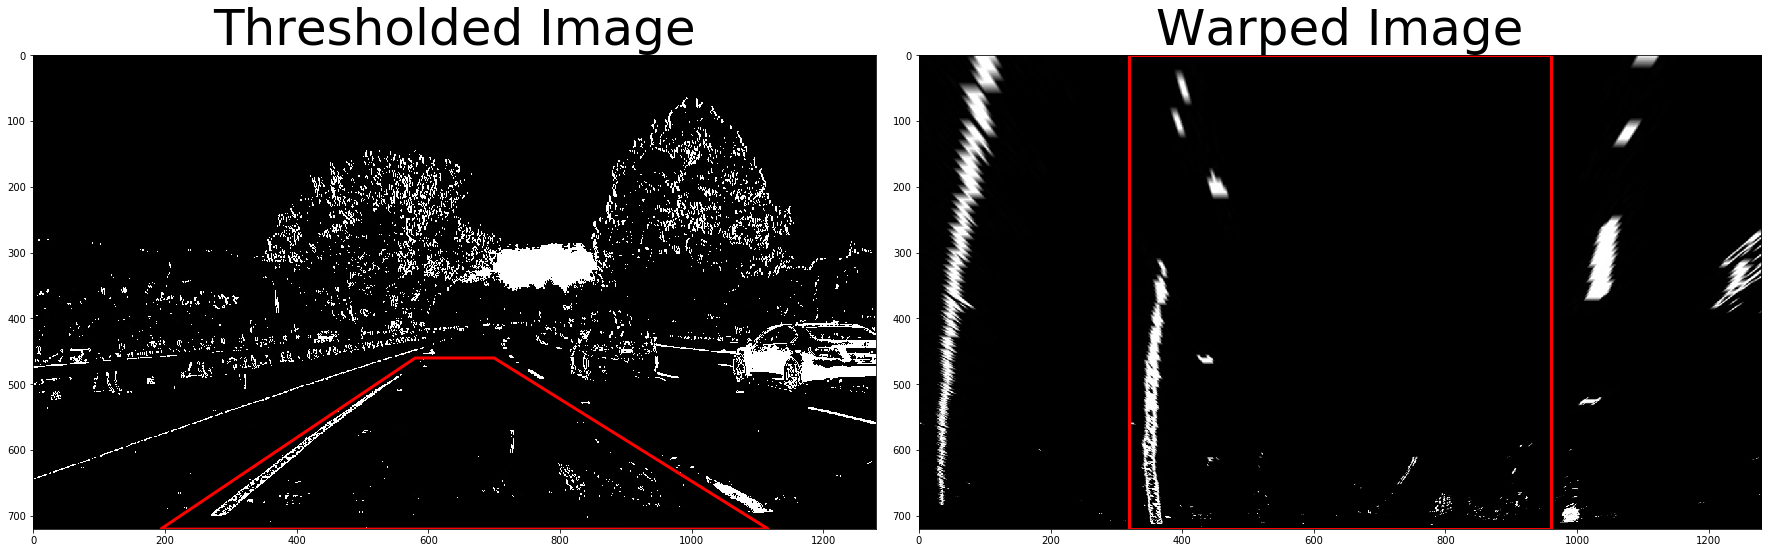

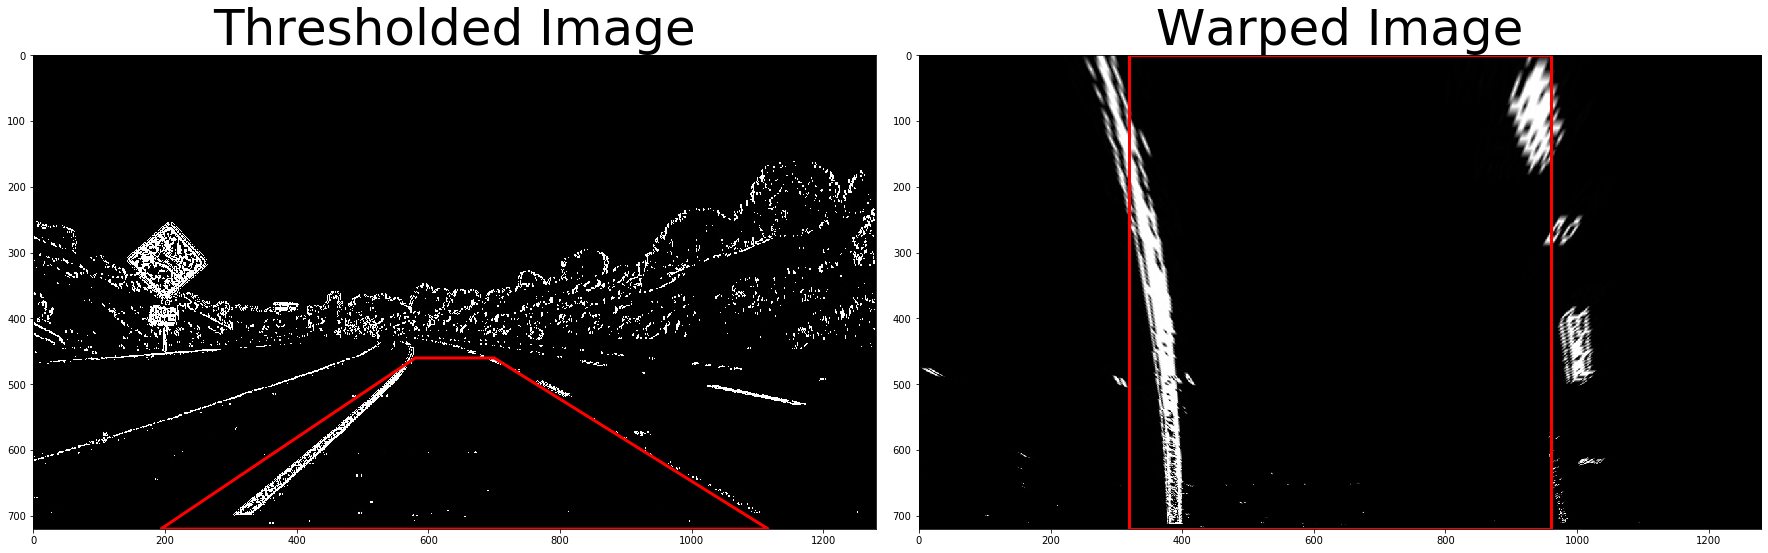

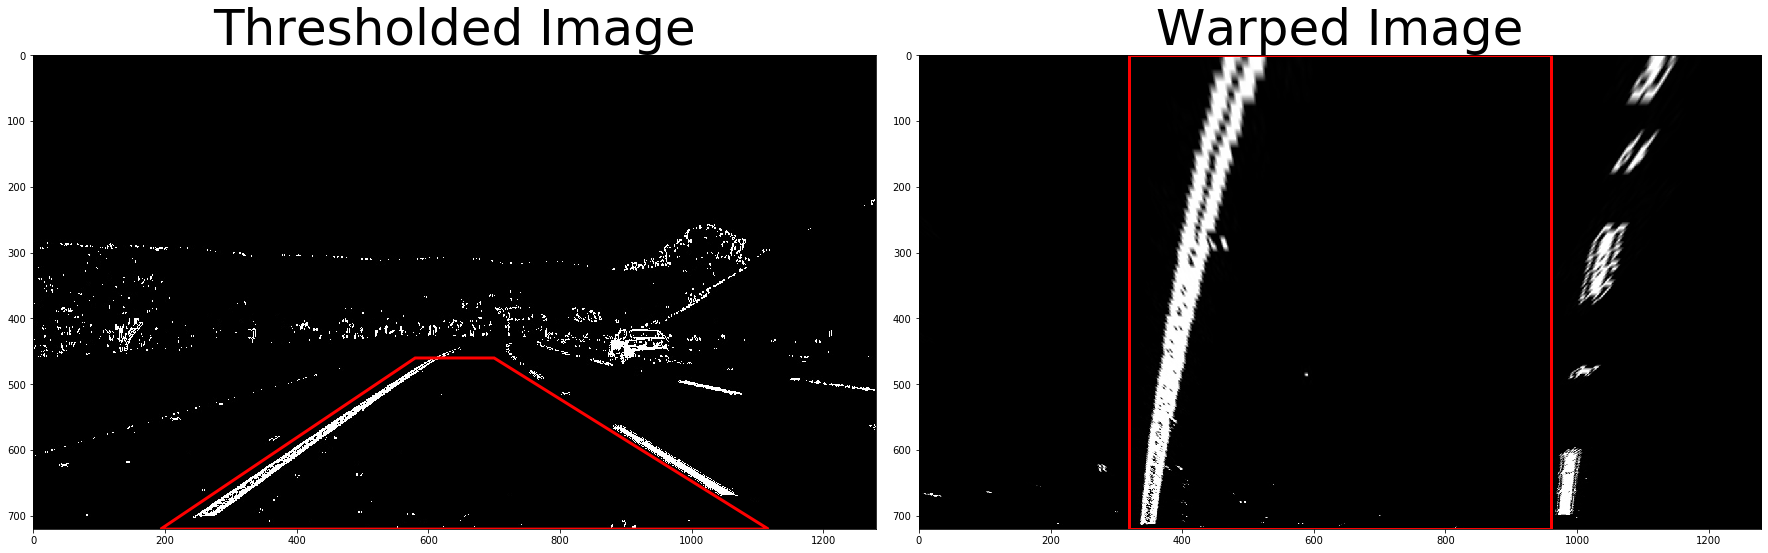

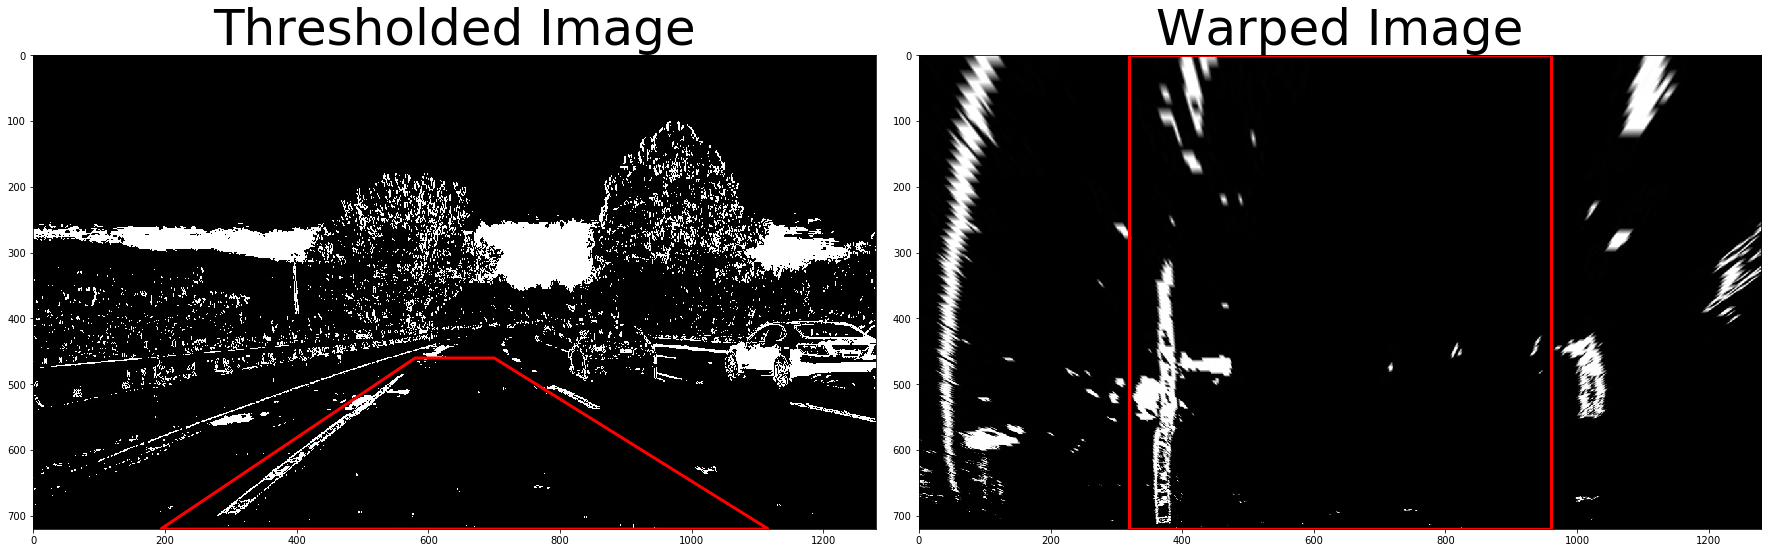

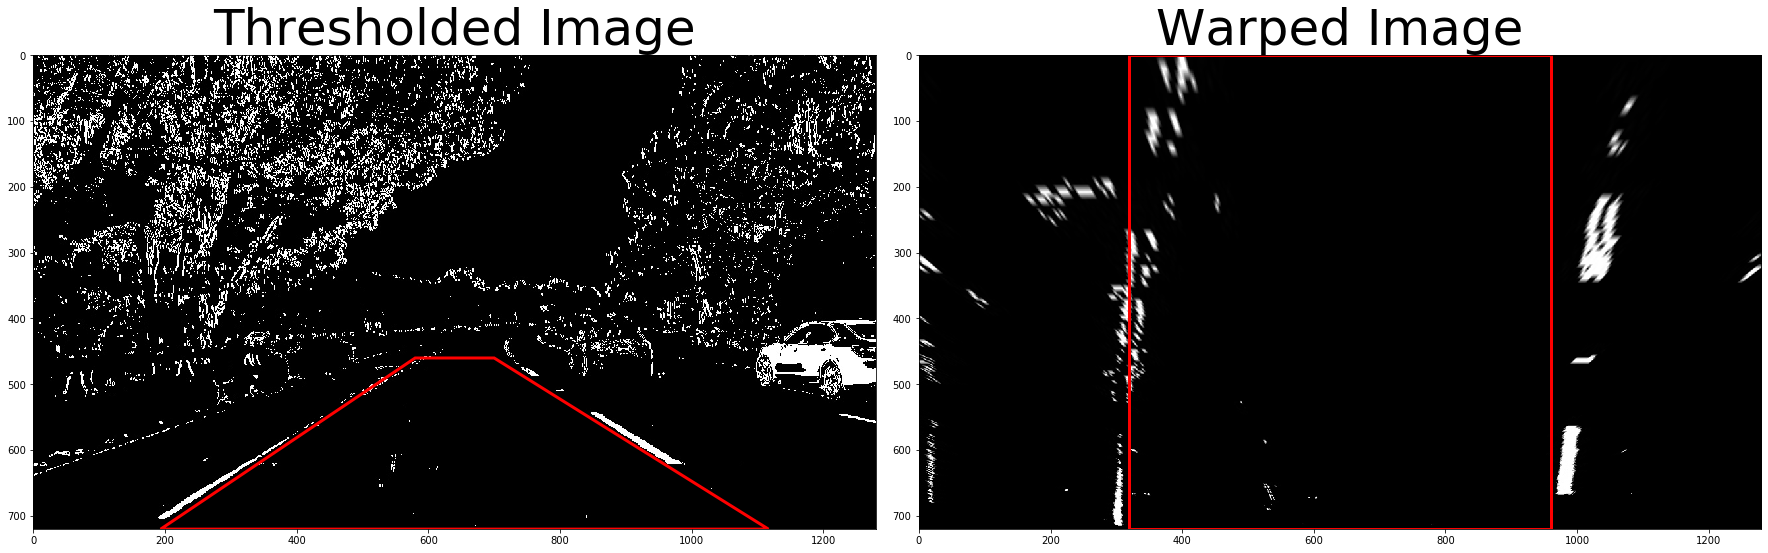

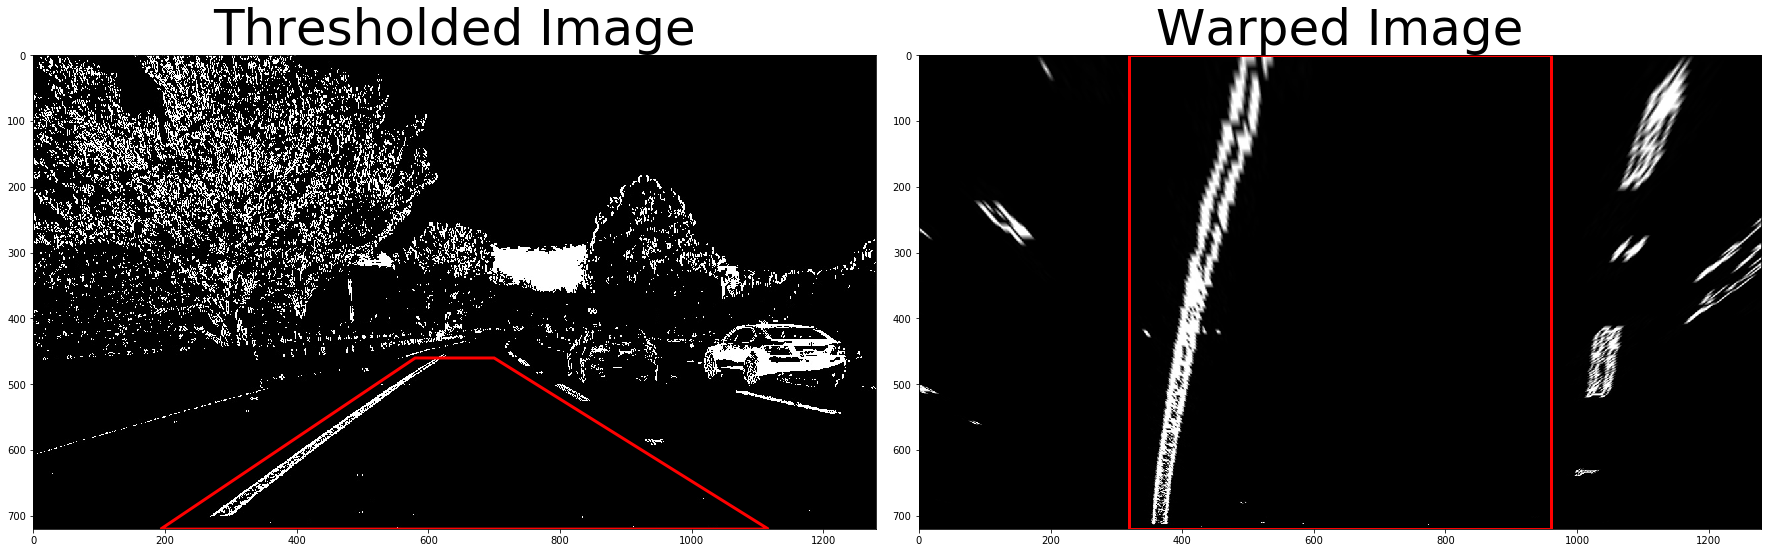

Done with perspective transform.


In [28]:
def warpimg(img, M):
    """ Warp image img using transform matrix M. """
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarpimg(img, Minv):
    """ Unwarp image img using transform matrix Minv. """
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped 

# Create warped directory, if it doesn't exist
warped_dir = 'output_images/warped/'
if not os.path.exists(warped_dir):
    os.mkdir(warped_dir)

# Make a list of thresholded images
threshimages = glob.glob(thresh_dir+'*.jpg')

# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 1

# get image size
img = cv2.imread(threshimages[0])
img_size = (img.shape[1], img.shape[0])
# source image offset from x-axis center
x_cent_off = 60
# source offset from y-axis center
y_cent_off = 100

# setup source and destination points for transform
src = np.float32(
[[(img_size[0] / 2) - x_cent_off, (img_size[1] / 2) + y_cent_off],
[((img_size[0] / 6) - 20), img_size[1]],
[(img_size[0] * 5 / 6) + 50, img_size[1]],
[(img_size[0] / 2) + x_cent_off, (img_size[1] / 2) + y_cent_off]])

dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3/4), img_size[1]],
[(img_size[0] * 3/4), 0]])

# get perspective transform matrix and inverse transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

idx = 0
# Step through the list and apply perspective transform
for fname in threshimages:
    idx += 1
    
    img = cv2.imread(fname)
    filename = os.path.basename(fname)
    warped = warpimg(img, M)
    cv2.imwrite(warped_dir+filename,warped)
    
    # Plot the original and warped images (convert back to RGB for matplotlib)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    warped = cv2.cvtColor(warped,cv2.COLOR_BGR2RGB)
    if all_debug_plots or idx == 1:        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        srcpoly = plt.Polygon(src, closed = True, fill = False, color = 'r', linewidth = 3)
        ax1.add_patch(srcpoly)
        ax1.imshow(img)
        ax1.set_title('Thresholded Image', fontsize=50)
        dstpoly = plt.Polygon(dst, closed = True, fill = False, color = 'r', linewidth = 3)
        ax2.add_patch(dstpoly)
        ax2.imshow(warped)
        ax2.set_title('Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        
print("Done with perspective transform.")

## Detect lane pixels and fit to find the lane boundary.

In [49]:
# Make a list of warped images
warpedimages = glob.glob(warped_dir+'*.jpg')

def binary_threshold(img):
    ret,binthresh = cv2.threshold(img,220,255,cv2.THRESH_BINARY)
    return binthresh

def find_lane_pixels_box(binary_warped):
    # Take a histogram of the bottom half of the image
    width = binary_warped.shape[1]
    height = binary_warped.shape[0]
    bottom_half = np.copy(binary_warped[height//2:,:])
    # Crop the image
    bottom_half[:,0:np.int(width/5)] = 0
    bottom_half[:,np.int(width*4/5):] = 0
    # Generate histogram
    histogram = np.sum(bottom_half, axis = 0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 150
    # Set number of pixels to classify as a sharp turn
    sharpturn = 40
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_inbounds = 1
    right_inbounds = 1
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left) 
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        win_y_high = binary_warped.shape[0] - window*window_height
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        
        if left_inbounds:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            
            ### Identify the nonzero pixels in x and y within the window ###
            good_left_inds = np.nonzero((nonzeroy > win_y_low) & \
                            (nonzeroy < win_y_high) & \
                            (nonzerox > win_xleft_low) & \
                            (nonzerox < win_xleft_high))[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            
            ### If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_left_inds) > minpix:
                new_leftx = np.mean(nonzerox[good_left_inds])
                diff = new_leftx - leftx_current
                if (diff >= sharpturn):
                    leftx_current = np.int(new_leftx + diff)
                elif (diff <= -sharpturn):
                    leftx_current = np.int(new_leftx + diff)
                else:
                    leftx_current = np.int(new_leftx)
                
        if right_inbounds:
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 


            good_right_inds = np.nonzero((nonzeroy > win_y_low) & \
                            (nonzeroy < win_y_high) & \
                            (nonzerox > win_xright_low) & \
                            (nonzerox < win_xright_high))[0]


            right_lane_inds.append(good_right_inds)


            if len(good_right_inds) > minpix:
                new_rightx = np.mean(nonzerox[good_right_inds])
                diff = new_rightx - rightx_current
                if (diff >= sharpturn):
                    rightx_current = np.int(new_rightx + diff)
                elif (diff <= -sharpturn):
                    rightx_current = np.int(new_rightx + diff)
                else:
                    rightx_current = np.int(new_rightx)
                    
        if win_xleft_low < 0 or win_xleft_high > binary_warped.shape[1]:
            left_inbounds = 0
        if win_xright_low < 0 or win_xright_high > binary_warped.shape[1]:
            right_inbounds = 0
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def find_lane_pixels_window(binary_warped, left_fit, right_fit, margin):

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###

    left_fitx = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    right_fitx = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    
    left_lane_inds = np.nonzero(np.abs(left_fitx - nonzerox) < margin)[0]
    right_lane_inds = np.nonzero(np.abs(right_fitx - nonzerox) < margin)[0]
                    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_lane_inds = np.nonzero(np.abs(left_fitx - nonzerox) < margin)[0]
    right_lane_inds = np.nonzero(np.abs(right_fitx - nonzerox) < margin)[0]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return leftx, lefty, rightx, righty, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    # Limit in case fit gives out of bounds values
    left_fitx = np.clip(left_fitx, a_min = 0, a_max = img_shape[1]-1) 
    right_fitx = np.clip(right_fitx, a_min = 0, a_max = img_shape[1]-1)
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def fit_poly_cr(leftx, lefty, rightx, righty):
    # Calculate fit in terms of meters
    ym_per_pix = 3.048/95 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit_cr, right_fit_cr

def fit_polynomial_window(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # The width of the margin around the previous polynomial to search
    margin = 80
    
    # Find lane pixels using window
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_window(binary_warped, left_fit, right_fit, margin)

    # Fit new polynomials
    left_fit_new, right_fit_new, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##    
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plots the left and right polynomials on the lane lines
    result[ploty.astype(int), left_fitx.astype(int)] = [255, 255, 0]
    result[ploty.astype(int), right_fitx.astype(int)] = [255, 255, 0]

    ## End visualization steps ##
    
    # Calculate fit in terms of meters
    left_fit_cr, right_fit_cr = fit_poly_cr(leftx, lefty, rightx, righty)
    
    return left_fit_new, right_fit_new, left_fit_cr, right_fit_cr, result

def fit_polynomial_box(binary_warped):
    
    # Find our lane pixels using box
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_box(binary_warped)

    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    out_img[ploty.astype(int), left_fitx.astype(int)] = [255, 255, 0]
    out_img[ploty.astype(int), right_fitx.astype(int)] = [255, 255, 0]

    # Calculate fit in terms of meters
    left_fit_cr, right_fit_cr = fit_poly_cr(leftx, lefty, rightx, righty)
    
    return left_fit, right_fit, left_fit_cr, right_fit_cr, out_img





## Determine the curvature of the lane and vehicle position with respect to center.

In [50]:
def measure_curvature_real(img, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/95 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = ym_per_pix*(img.shape[0]-1)
    
    ##### Calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5/np.abs(2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5/np.abs(2*right_fit_cr[0])
    
    # Calculate center offset
    car_position = img.shape[1]/2*xm_per_pix
    left_lane_pos = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_lane_pos = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    lane_center_position = (right_lane_pos + left_lane_pos) /2
    center_offset = (car_position - lane_center_position)
        
    return left_curverad, right_curverad, center_offset

## Warp the detected lane boundaries back onto the original image.

In [54]:
def draw_lane_bounds(warped, undist, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    height, width = warped.shape
    ploty = np.linspace(0, height-1, num=height)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (width, height)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Left curvature radius: 28.157287271282378 meters
Right curvature radius: 378.21313889556023 meters
Center offset: -0.16402718555273665 meters


ValueError: x and y can be no greater than 2-D, but have shapes (720,) and (720, 1280, 3)

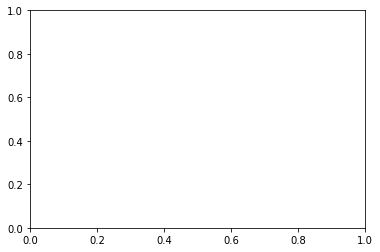

In [55]:
# set to 1 to display plots of all images, 0 to display only a single image
all_debug_plots = 1

idx = 0
# Step through the list and apply perspective transform
for fname in warpedimages:
    idx += 1
    
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    undist = cv2.imread(undistimages[idx-1])
    filename = os.path.basename(fname)
    binary = binary_threshold(img)
    left_fit, right_fit, left_fit_cr, right_fit_cr, box_img = fit_polynomial_box(binary)
    left_fit, right_fit, left_fit_cr, right_fit_cr, window_img = fit_polynomial_window(binary, left_fit, right_fit)
    left_curv_rad, right_curv_rad, center_offset = measure_curvature_real(binary, left_fit_cr, right_fit_cr)
    print("Left curvature radius: " + str(left_curv_rad) + " meters")
    print("Right curvature radius: " + str(right_curv_rad) + " meters")
    print("Center offset: " + str(center_offset) + " meters")
    #cv2.imwrite(warped_dir+filename,warped)
    final_img = draw_lane_bounds(binary, undist, left_fit, right_fit, Minv)
    plt.plot(final_img)
    # Plot the original and histogram images (convert back to RGB for matplotlib)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if all_debug_plots or idx == 1:        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(box_img)
        ax1.set_title('Box Image', fontsize=50)
        ax2.imshow(window_img)
        ax2.set_title('Window Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

## Process a project video.

In [ ]:
# Create output videos directory, if it doesn't exist
outvid_dir = 'output_videos/'
if not os.path.exists(outvid_dir):
    os.mkdir(outvid_dir)
    
project_output = outvid_dir + 'project_video.mp4'
##clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
proj_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(project_output, audio=False)

## Play the output video inline.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Process a challenge video.

In [ ]:
# Create output videos directory, if it doesn't exist
outvid_dir = 'output_videos/'
if not os.path.exists(outvid_dir):
    os.mkdir(outvid_dir)
    
challenge_output = outvid_dir + 'challenge_video.mp4'
##clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

## Play the output video inline.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Process a harder challenge video.

In [ ]:
# Create output videos directory, if it doesn't exist
outvid_dir = 'output_videos/'
if not os.path.exists(outvid_dir):
    os.mkdir(outvid_dir)
    
hardchallenge_output = outvid_dir + 'harder_challenge_video.mp4'
##clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4")
hardchallenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time hardchallenge_clip.write_videofile(hardchallenge_output, audio=False)


## Play the output video inline.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hardchallenge_output))